# Isomap

---

## Exercise 1

- Write your own implementation of Isomap.

- Apply it to the Swiss Roll dataset ($n = 1000$) from Lab 1.

- Use a modified version of the Swiss Roll dataset, in which Gaussian noise from a Normal $N(\mu = 0, \sigma = 0.5)$ is added to the $x$ and $y$ coordinates. Apply Isomap to this dataset and discuss the differences with the previous point.

In [2]:
from sklearn.neighbors import NearestNeighbors
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Let's start by generating our Swiss Roll datasets with $n = 1000$.

In [3]:
# SWISS ROLL (standard)

# Sampling
n = 1000
phi = np.random.uniform(1.5*np.pi, 4.5*np.pi, n)
psi = np.random.uniform(0, 10, n)

# Coordinates
x = phi*np.cos(phi)
y = phi*np.sin(phi)
z = psi

# Create a dataframe from the coordinates
data = {
    'x': x,
    'y': y,
    'z': z
}
X = pd.DataFrame(data)
X

,x,y,z
0,5.178499,-2.638545,0.632434
1,-8.348928,3.448465,9.842905
2,4.941013,-2.935301,0.081982
3,-8.602209,-5.003655,8.755503
4,5.990941,3.145991,6.295168
...,...,...,...
995,-7.276436,-7.149983,2.547679
996,-5.376703,-8.967014,5.908143
997,4.731100,12.949710,1.727158
998,6.342637,1.472271,2.267604


In [4]:
# SWISS ROLL (noisy)

# Noise
noise_x = np.random.normal(0, 0.5, n)
noise_y = np.random.normal(0, 0.5, n)

# Coordinates
x = phi * np.cos(phi) + noise_x
y = phi * np.sin(phi) + noise_y
z = psi

# Create a dataframe from the coordinates
data = {
    'x': x,
    'y': y,
    'z': z
}
X_noisy = pd.DataFrame(data)
X_noisy

,x,y,z
0,5.728134,-2.735166,0.632434
1,-8.390371,3.025250,9.842905
2,3.526647,-3.055275,0.081982
3,-8.450996,-5.758281,8.755503
4,5.521914,3.315989,6.295168
...,...,...,...
995,-6.493496,-7.688222,2.547679
996,-6.137034,-9.639903,5.908143
997,4.943723,12.052142,1.727158
998,6.459127,1.490732,2.267604


We must also define the algorithm we will use to compute the minimum path between nodes in the graph: Dijkstra.

In [5]:
def dijkstra(g, source):
    dist = {v: np.inf for v in g.nodes}
    dist[source] = 0
    visited = set()
    queue = set(g.nodes)

    while queue:
        u = min((v for v in queue), key=lambda v: dist[v])
        queue.remove(u)
        visited.add(u)

        for neighbor, attr in g[u].items():
            if neighbor in queue:
                alt = dist[u] + attr['weight']
                if alt < dist[neighbor]:
                    dist[neighbor] = alt
    return dist

Now we can code our Isomap function.

**Isomap** is a non-linear dimensionality reduction technique designed to "unroll" complex, curved data manifolds to reveal their simpler, underlying geometry. It operates in three steps:

- First, it approximates the local structure of the data by creating a neighborhood graph, connecting each point only to its k nearest neighbors.
- Second, it estimates the geodesic distance between all pairs of points by finding the shortest route through this graph.
- Finally, it uses this matrix of geodesic distances to create a new, low-dimensional "map" (an embedding) where the straight-line distances between points preserve these original curved-path distances, effectively flattening the manifold without tearing it.

In [ ]:
def geosdesic_distance(g):
    nodes = sorted(list(g.nodes))
    delta = np.zeros((len(nodes), len(nodes)))

    for i, source in enumerate(nodes):
        dist_dict = dijkstra(g, source)
        
        for j in range(i, len(nodes)):
            target = nodes[j]
            
            if target in dist_dict:
                delta[i, j] = dist_dict[target]
                delta[j, i] = dist_dict[target]
            else:
                delta[i, j] = np.inf
                delta[j, i] = np.inf

    return delta


def isomap(x, n_components, n_neighbors=5):
    
    # Nearest Neighbors
    neigh = NearestNeighbors(n_neighbors=n_neighbors)
    neigh.fit(x)
    neigh_dist, neigh_idx = neigh.kneighbors()
    
    # Neighbor Graph
    g = nx.Graph()
    for i in range(x.shape[0]):
        for j in range(len(neigh_idx[i])):
            neighbor_index = neigh_idx[i][j]
            distance = neigh_dist[i][j]
            g.add_edge(i, neighbor_index, weight=distance)
    
    if not nx.is_connected(g):
        raise ValueError(
            f"Graph is not connected with n_neighbors={n_neighbors}. "
            "Please increase n_neighbors."
        )

    # Distance matrix (by Dijkstra)
    delta = geosdesic_distance(g)

    # Double centering
    delta_squared = delta ** 2
    row_avg = np.mean(delta_squared, axis=1)
    col_avg = np.mean(delta_squared, axis=0)
    total_avg = np.mean(delta_squared)
    gram_matrix = -0.5 * (delta_squared - row_avg[:, np.newaxis] - col_avg[np.newaxis, :] + total_avg)

    # Eigen decomposition
    eigenvalues, eigenvectors = np.linalg.eigh(gram_matrix)
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]

    # Final coordinates
    top_eigenvalues = eigenvalues[:n_components]
    top_eigenvectors = eigenvectors[:, :n_components]
    
    # Ensure no negative eigenvalues
    positive_eigenvalues = np.maximum(top_eigenvalues, 0)
    
    # Coordinates = Eigenvectors * sqrt(Eigenvalues)
    embedded_coordinates = top_eigenvectors @ np.diag(np.sqrt(positive_eigenvalues))

    return embedded_coordinates

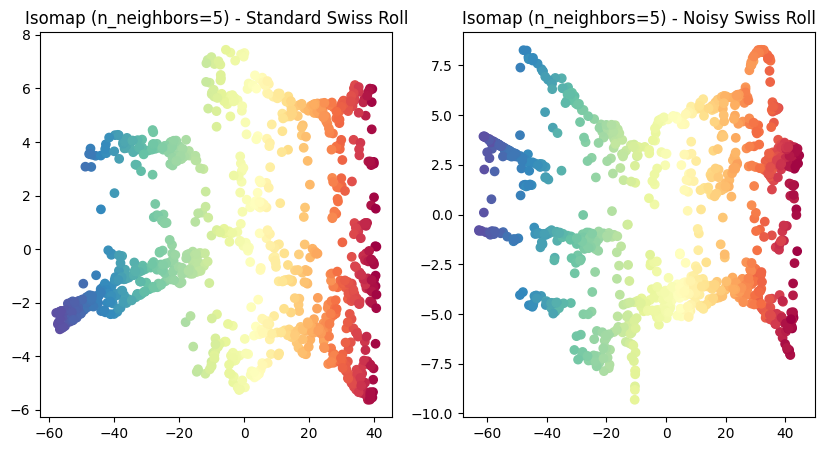

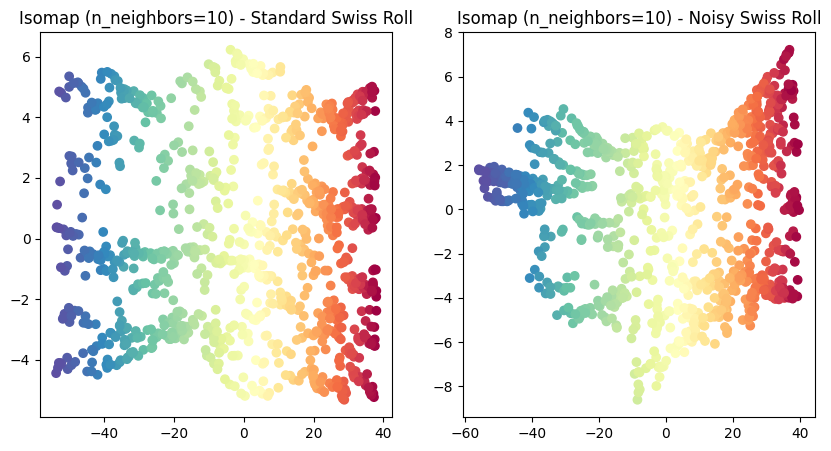

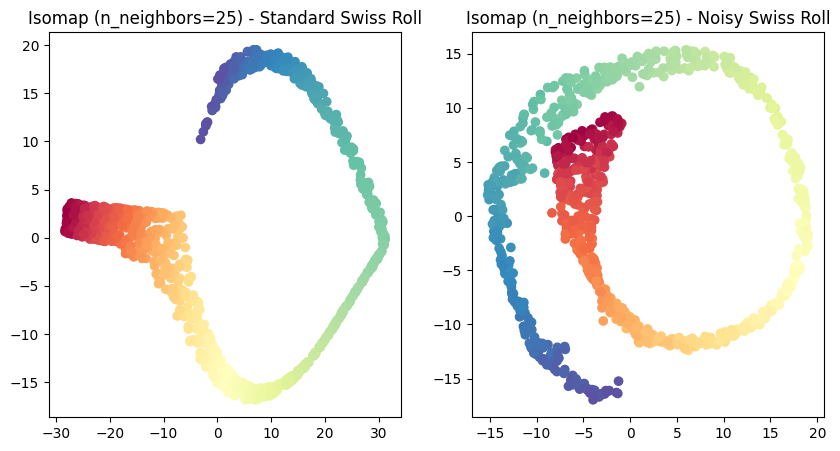

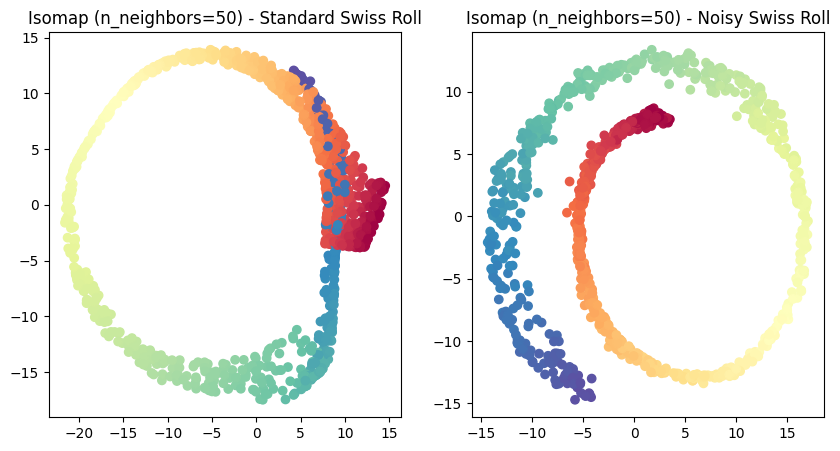

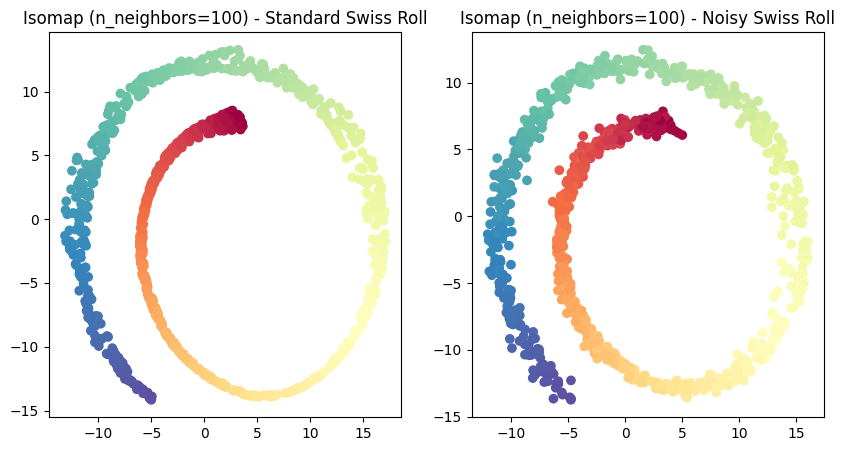

In [8]:
# Projection of MDS
for n in [5, 10, 25, 50, 100]:
    y = isomap(X, n_components=2, n_neighbors=n)
    y_noisy = isomap(X_noisy, n_components=2, n_neighbors=n)

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].scatter(y[:, 0], y[:, 1], c=phi, cmap='Spectral')
    axs[0].set_title(f'Isomap (n_neighbors={n}) - Standard Swiss Roll')
    axs[1].scatter(y_noisy[:, 0], y_noisy[:, 1], c=phi, cmap='Spectral')
    axs[1].set_title(f'Isomap (n_neighbors={n}) - Noisy Swiss Roll')
    plt.show()

---
## Exercise 2 

Undersample randomly from the `Dry Bean Dataset` in order to have $n = 1000$ datapoints. Follow the same pipeline of Exercise 1 of the previous lab () by replacing PCA with Isomap. Discuss the differences with particular focus on the accuracy of the logistic regression.

Important note: in this case, you don’t need to do the train-test split. Apply ISOMAP to the whole dataset first, and then do the train-test split and follow the rest of the pipeline.

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

Let's start by loading the dataset:

In [62]:
# Load the dataset
path = "../Datasets/Dry_Bean_Dataset.xlsx"
df = pd.read_excel(path)
df

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272750,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13606,42097,759.696,288.721612,185.944705,1.552728,0.765002,42508,231.515799,0.714574,0.990331,0.916603,0.801865,0.006858,0.001749,0.642988,0.998385,DERMASON
13607,42101,757.499,281.576392,190.713136,1.476439,0.735702,42494,231.526798,0.799943,0.990752,0.922015,0.822252,0.006688,0.001886,0.676099,0.998219,DERMASON
13608,42139,759.321,281.539928,191.187979,1.472582,0.734065,42569,231.631261,0.729932,0.989899,0.918424,0.822730,0.006681,0.001888,0.676884,0.996767,DERMASON
13609,42147,763.779,283.382636,190.275731,1.489326,0.741055,42667,231.653248,0.705389,0.987813,0.907906,0.817457,0.006724,0.001852,0.668237,0.995222,DERMASON


Now some preprocessing is needed:

- Random sampling of $n=1000$ elements.
- Separate features and target variable.
- Center and scale the features

In [68]:
# Undersampling
df = df.sample(n=1000, random_state=42)

# Separate features (X) and target (y)
X = df.drop('Class', axis=1)
y = df['Class']

# Class to number
y_numerical, class_names = pd.factorize(y)

# Center and scale the data
X = (X - X.mean()) / X.std()

In [69]:
# Isomap
embedded_coordinates = isomap(X, n_components=16, n_neighbors=15)

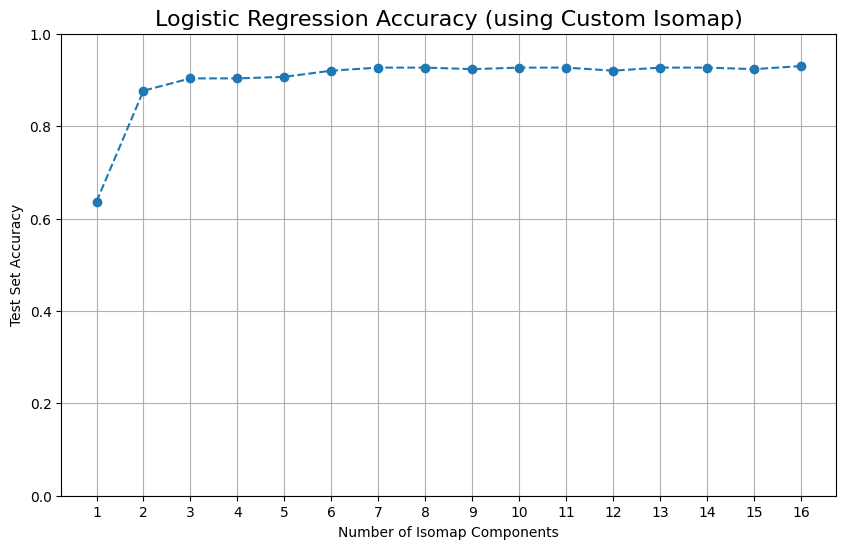

Maximum accuracy of 0.9300 was achieved with 16 components.


In [70]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    embedded_coordinates, y, test_size=0.3, random_state=42, stratify=y
)

# Loop and evaluate logistic regression
accuracies = []
n_components_range = range(1, 17)

for n_comp in n_components_range:
    X_train_subset = X_train[:, :n_comp]
    X_test_subset = X_test[:, :n_comp]

    log_reg = LogisticRegression(solver='lbfgs', max_iter=1000)
    log_reg.fit(X_train_subset, y_train)

    y_pred = log_reg.predict(X_test_subset)
    accuracies.append(accuracy_score(y_test, y_pred))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(n_components_range, accuracies, marker='o', linestyle='--')
plt.title('Logistic Regression Accuracy (using Custom Isomap)', fontsize=16)
plt.xlabel('Number of Isomap Components')
plt.ylabel('Test Set Accuracy')
plt.xticks(n_components_range)
plt.ylim(0, 1.0)
plt.grid(True)
plt.show()

print(f"Maximum accuracy of {max(accuracies):.4f} was achieved with {np.argmax(accuracies) + 1} components.")

The logistic regression model's accuracy increased dramatically with the first few Isomap components, rising from 40% to over 90% with just six components. This indicates that the initial components successfully captured the most significant geometric structure of the data, transforming it into a space where the classes became nearly linearly separable. The performance then plateaued at a peak accuracy of 93% around 7-11 components, showing that the later components offered diminishing returns. This confirms that Isomap successfully unrolled the data manifold, creating a powerful low-dimensional representation ideal for the classification task.